In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from pprint import pprint
import random
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
import scipy
import scipy.stats as stats

In [3]:
import fractopo_subsampling.utils as utils
import fractopo_subsampling.plotting_utils as plotting_utils
from fractopo_subsampling.schema import describe_df_schema
import subsampling_config

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


# Notebook Parametrization

Collection of some configurations that control the subsampling. Not exhaustive.

In [4]:
radius_constraint = 1.0
min_radius = 0.0
max_radius = 26.0
# Step 1 subsamplings have been collected into a single csv with gather-subsampling invoke cmd
# Path to that csv:
data_path_str = "../results/subsampling/collected/Subsampling_results_12042021.csv"
iterations = 10000
save = True

# Read data

In [5]:
data_path = Path(data_path_str)
save_path = subsampling_config.results_path
subsampling_path = subsampling_config.subsampling_path

assert all(path.exists() for path in (data_path, save_path, subsampling_path))

full_df = pd.read_csv(data_path, sep=";", index_col=[0])
# Validate
full_df = describe_df_schema.validate(full_df)

Reference values from base circle analysis:

In [6]:
reference_values = pd.read_csv(subsampling_config.base_circle_reference_value_csv_path)
reference_value_dict = {
    name: value
    for name, value in zip(reference_values["Parameter"], reference_values["Value"])
}

In [7]:
reference_value_dict["trace power_law exponent"] = reference_value_dict[
    "Trace Power-law Exponent"
]
reference_value_dict["branch power_law exponent"] = reference_value_dict[
    "Branch Power-law Exponent"
]

In [8]:
reference_value_dict

{'Connections per Branch': 1.4435,
 'Trace Power-law Exponent': -1.7546,
 'Branch Power-law Exponent': -2.9051,
 'Fracture Intensity P21': 2.0089,
 'trace power_law exponent': -1.7546,
 'branch power_law exponent': -2.9051}

# Describe data

In [9]:
full_df.shape[0]

1093

In [10]:
full_df.describe()

,X,Y,I,E,C - C,C - I,I - I,C - E,I - E,E - E,...,Trace Boundary 0 Intersect Count,Trace Boundary 1 Intersect Count,Trace Boundary 2 Intersect Count,Branch Boundary 0 Intersect Count,Branch Boundary 1 Intersect Count,radius,area,coverage,relative coverage,Branch Boundary 2 Intersect Count
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,...,1082.000000,1085.000000,712.000000,1082.000000,1085.000000,1093.000000,1093.000000,1093.000000,1093.000000,303.000000
mean,183.762123,641.052150,970.334858,75.064959,996.810613,611.281793,168.995425,53.283623,21.129003,0.362306,...,777.020333,73.434101,1.691011,1795.154344,74.989862,13.665973,690.483275,36.267154,0.045829,1.306931
std,303.485829,953.958438,1350.112618,59.027531,1572.948087,891.233385,225.958826,44.820032,15.415871,0.667486,...,1120.482296,58.402934,0.874729,2671.338934,58.527037,5.749703,533.302798,42.643795,0.041106,0.610220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,5.015920,79.040745,0.000000,0.000000,1.000000
25%,24.000000,95.000000,189.000000,30.000000,120.000000,106.000000,27.000000,19.000000,10.000000,0.000000,...,134.250000,29.000000,1.000000,283.000000,30.000000,8.537542,228.989523,3.980837,0.014651,1.000000
50%,69.000000,276.000000,455.000000,60.000000,388.000000,270.000000,86.000000,41.000000,17.000000,0.000000,...,335.000000,59.000000,1.000000,749.500000,60.000000,13.106262,539.644292,21.045292,0.039581,1.000000
75%,216.000000,829.000000,1246.000000,108.000000,1289.000000,781.000000,227.000000,78.000000,29.000000,1.000000,...,1006.500000,106.000000,2.000000,2291.250000,107.000000,18.263757,1047.924731,54.329016,0.061765,1.000000
max,2276.000000,6515.000000,10185.000000,343.000000,10937.000000,6747.000000,1674.000000,257.000000,91.000000,4.000000,...,8201.000000,341.000000,6.000000,19269.000000,341.000000,24.930954,1952.664635,200.009860,0.389207,4.000000


In [11]:
sum(full_df["Fracture Intensity P21"] == 0)

4

# Data preprocessing

Full dataset contains more simulation data in a spatially extensive area. The dataset is filtered to a more concentrated area spanning roughly 4.5 km.

In [12]:
# Keys in the dict are the target area names that we are interested in.
subsampling_config.circle_names_with_diameter

{'Getaberget_20m_4_3_area': 50,
 'Getaberget_20m_9_2_area': 50,
 'Getaberget_20m_8_3_area': 50,
 'Getaberget_20m_7_1_area': 50,
 'Getaberget_20m_7_2_area': 20,
 'Getaberget_20m_5_1_area': 50,
 'Getaberget_20m_2_1_area': 40,
 'Getaberget_20m_2_2_area': 50,
 'Getaberget_20m_1_1_area': 50,
 'Getaberget_20m_1_2_area': 40,
 'Getaberget_20m_1_3_area': 20,
 'Getaberget_20m_1_4_area': 50,
 'Havsvidden_20m_1_area': 50}

In [13]:
# All circles
len(full_df["name"].unique())

20

Dataset contains named circles that are not spatially close to the others, filter to only a concentrated set of circles (subsampling_config.circle_names_with_diameter).

In [14]:
df = full_df.loc[
    np.isin(full_df["name"], list(subsampling_config.circle_names_with_diameter))
]
len(df["name"].unique())

13

Filter out circles with too high of a coverage (15 %).

In [15]:
# How many are there with lower?
sum(df["relative coverage"] > 0.15)

15

In [16]:
# Filter
df = df.loc[df["relative coverage"] < 0.15]

Filter out circles with less than 30 I- and Y-nodes within the circle according to recommendation of Rohrbaugh et al. 2002.

In [17]:
more_than = df["Y"] + df["I"] > 30
print(f"There were {sum(~more_than)} circles with less than 30 IY-nodes.")
df = df.loc[more_than]

There were 3 circles with less than 30 IY-nodes.


In [18]:
# Simulation circle count at this point
df.shape[0]

664

In [19]:
def only_half_radius(subsampled_radius, full_diameter, radius_constraint):
    return subsampled_radius <= ((full_diameter / 2) * radius_constraint)

Filter by radius (if wanted)

In [20]:
print(f"Before radius filter {df.shape[0]}")
df = df.loc[
    [
        only_half_radius(
            subsampled_radius,
            subsampling_config.circle_names_with_diameter[name],
            radius_constraint,
        )
        for subsampled_radius, name in zip(df["radius"], df["name"])
    ]
]
print(f"After radius filter {df.shape[0]}")

Before radius filter 664
After radius filter 664


The dataset is grouped by target area name.

In [21]:
df_grouped = df.groupby("name")
len(df_grouped)

13

# Analysis of all datasets

The full dataset can be used to fuel the second step of full subsampling:

* A count of one to all of target area circles are chosen
* From each target area circle one subsampled circle is chosen.

This simulates areal sampling with (multiple) sample circles with varying radius. Only one circle per target area is chosen so spatial variance on the scale of the whole outcrop is always a factor.

Because the base circle radii vary the random subsampling is weighted by the area of the circle so larger circles are picked more often.

It is possible to concentrate the subsampling to e.g. subsampled circles that are within a minimum and maximum area range.

In [22]:
subsample_area_limits = (
    utils.radius_to_area(min_radius),
    utils.radius_to_area(max_radius),
)

We cache the results of the Step 2 subsampling to speed up notebook runs. The filepath for the cache is sensitive to any changes in the underlying `df` dataset and reruns will occur if e.g. the size, loaded `df` filepath or constraints change (Change detection by no means absolute, user responsibility to rerun if needed.).

In [23]:
df_hash = df.shape[0]
radius_constraint_hash = int(radius_constraint * 100)
data_path_hash = data_path.stem

subsample_area_limits_hash = int(sum(subsample_area_limits))

savepath = (
    subsampling_config.results_path
    / f"subsampling/cached_subsamples/agg_df_{df_hash}_{radius_constraint_hash}_{iterations}_{data_path_hash}_{subsample_area_limits_hash}.csv"
)

# If the subsampling has already been conducted for current dataset it can be loaded from cache
agg_df = utils.cached_subsampling(
    dataframe_grouped=df_grouped,
    iterations=iterations,
    savepath=savepath,
    subsample_area_limits=subsample_area_limits,
    circle_names_with_diameter=subsampling_config.circle_names_with_diameter,
)

In [24]:
agg_df.describe()

,area,circle_count,Connections per Branch,trace power_law exponent,branch power_law exponent,Fracture Intensity P21,Number of Traces,Number of Branches,radius,I,Y,X,Trace Boundary 1 Intersect Count,Trace Boundary 2 Intersect Count,Trace Boundary 0 Intersect Count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,2095.000000,10000.000000
mean,5142.046407,7.003800,1.439806,-1.735742,-2.728142,2.008698,10124.504150,22971.723450,99.236229,12140.927200,8108.081100,2369.569100,770.77370,6.112649,9738.354200
std,2967.127156,3.741816,0.039069,0.228854,0.399152,0.338399,6132.765702,14040.274576,53.654736,7339.653858,4944.982407,1492.764583,419.08288,4.845335,5931.754293
min,80.305162,1.000000,1.024194,-3.755718,-7.169715,0.905161,36.500000,67.500000,5.055880,52.000000,21.000000,5.000000,15.00000,1.000000,28.000000
25%,2643.646710,4.000000,1.423802,-1.864491,-2.875227,1.807954,4891.625000,10958.375000,52.900205,5902.000000,3879.000000,1103.000000,410.00000,2.000000,4679.000000
50%,5115.294556,7.000000,1.440022,-1.736911,-2.687855,1.967777,9940.500000,22465.500000,100.485916,11912.000000,7948.500000,2300.000000,792.00000,5.000000,9531.500000
75%,7406.138218,10.000000,1.456539,-1.607094,-2.521974,2.145098,14718.250000,33466.000000,144.162552,17627.000000,11815.250000,3459.000000,1117.00000,9.000000,14175.250000
max,15417.577580,13.000000,1.660799,-0.550155,-1.178875,4.632121,31132.000000,70787.000000,242.618430,37579.000000,24685.000000,7552.000000,1878.00000,28.000000,30184.000000


# Variance when whole sample areas are categorized

The areas and sample counts in each simulation can be used to categorize the simulations to visualize the difference between area amount and sample count and their relation to each other. 

## Effect of boundary censoring (not used!)

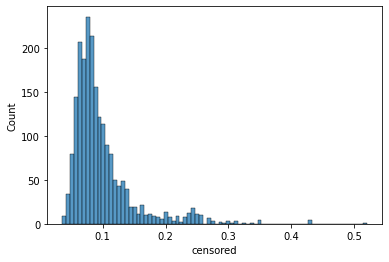

In [25]:
agg_df["censored"] = (
    agg_df["Trace Boundary 1 Intersect Count"]
    + agg_df["Trace Boundary 2 Intersect Count"]
) / agg_df["Number of Traces"]
sns.histplot(data=agg_df, x="censored")
censored_bins = [0, 0.1, 0.2, 1.1]
censored_labels = ["0-10%", "10-20%", "20%+"]
agg_df["censored_binned"] = pd.cut(
    agg_df["censored"], censored_bins, labels=censored_labels
)

## Effect of endpoints (not used!)

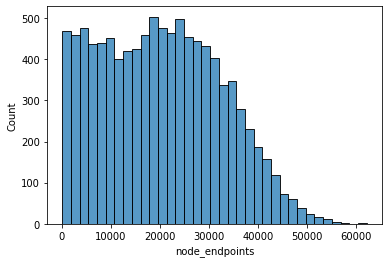

In [26]:
agg_df["node_endpoints"] = agg_df["Y"] + agg_df["I"]
sns.histplot(data=agg_df, x="node_endpoints")
yi_bins = [0, 15000, 30000, 10e10]
yi_labels = ["0-15k", "15k-30k", "30k+"]
agg_df["node_endpoint_binned"] = pd.cut(
    agg_df["node_endpoints"], yi_bins, labels=yi_labels
)

## Effect of total area and circle count (used!)

In [27]:
# Bin iterations based on total sample area in the iteration
area_bins = [0, 4000, 8000, 20000]
area_labels = ["0-4", "4-8", "8-20"]
agg_df["area_binned"] = pd.cut(agg_df["area"], area_bins, labels=area_labels)

# Bin iterations based on total circle count in the iteration
cc_bins = [0, 5, 8, 11, 14]
cc_labels = ["1-4", "5-7", "8-10", "11-13"]
agg_df["circle_count_binned"] = pd.cut(
    agg_df["circle_count"], cc_bins, labels=cc_labels
)

In [28]:
level_grouped = agg_df.groupby(["area_binned", "circle_count_binned"])

In [29]:
print(level_grouped.area.count().unstack(level=-1).to_markdown(tablefmt="grid"))

+---------------+-------+-------+--------+---------+
| area_binned   |   1-4 |   5-7 |   8-10 |   11-13 |
+===============+=======+=======+========+=========+
| 0-4           |  3346 |   473 |     30 |       1 |
+---------------+-------+-------+--------+---------+
| 4-8           |   443 |  1796 |   1440 |     545 |
+---------------+-------+-------+--------+---------+
| 8-20          |     0 |   123 |    823 |     980 |
+---------------+-------+-------+--------+---------+


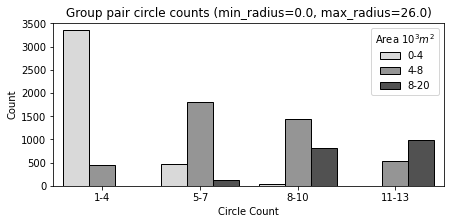

In [30]:
fig = plotting_utils.plot_group_pair_counts(
    agg_df=agg_df,
    x="circle_count_binned",
    hue="area_binned",
    ylabel="Count",
    xlabel="Circle Count",
    title=f"Group pair circle counts ({min_radius=}, {max_radius=})",
    legend_title=r"Area $10^3m^2$",
)
if save:
    fig.savefig(
        f"{subsampling_path}/boxplots/circle_amounts_{subsample_area_limits_hash}.svg",
        bbox_inches="tight",
    )

Filter group pairs with very low iteration count (less than 100 samples AND less than 1% of total samples in group pair) as they offer "bad" boxplots.

In [31]:
full_length = agg_df.shape[0]
smol_groups = []
for cc in cc_labels:
    for aa in area_labels:
        query = np.logical_and(
            agg_df["circle_count_binned"] == cc, agg_df["area_binned"] == aa
        )

        if sum(query) / full_length < 0.01 and sum(query) < 100:
            smol_groups.append((cc, aa))

filterer = [True] * full_length
for cc, aa in smol_groups:
    group_filterer = [
        not (circle_cc == cc and area_aa == aa)
        for circle_cc, area_aa in zip(
            agg_df["circle_count_binned"], agg_df["area_binned"]
        )
    ]
    filterer = np.logical_and(filterer, group_filterer)

filtered_agg = agg_df.loc[filterer]

print(f"Filtered {full_length - filtered_agg.shape[0]} iterations.")

Filtered 31 iterations.


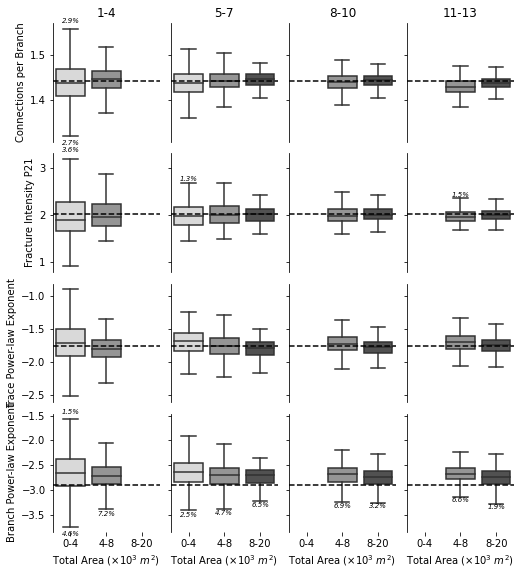

In [32]:
fig = plotting_utils.grouped_boxplots(
    aggregate_df=filtered_agg,
    reference_value_dict=reference_value_dict,
    group_col_first="circle_count_binned",
    group_col_second="area_binned",
    group_first_labels=cc_labels,
    group_second_labels=area_labels,
)
savepath = Path(f"{subsampling_path}/boxplots/grouped_boxplots.svg")
if save:
    fig.savefig(savepath, bbox_inches="tight")

## Discussion

We fit beta distributions to two group pairs for two parameters. All relevant statistics are within the plots.

In [33]:
circle_groups = ("5-7", "8-10")
area_groups = ("4-8", "4-8")

params = ("Fracture Intensity P21", "trace power_law exponent")

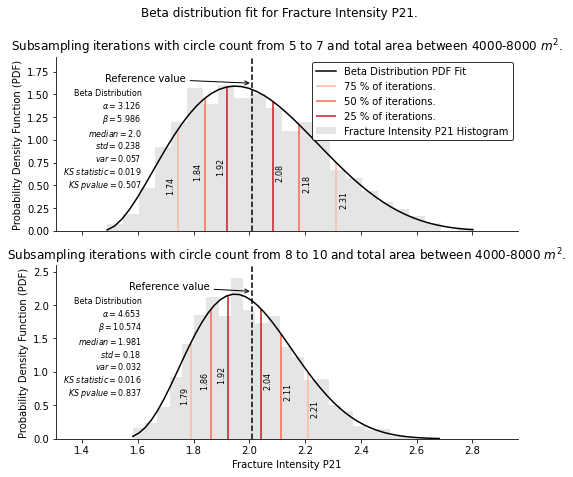

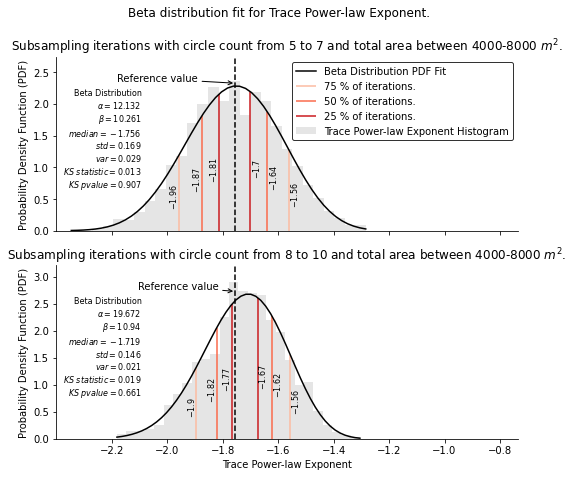

In [34]:
for param in params:
    # Initialize plot
    fig, axes = plt.subplots(2, 1, figsize=utils.paper_figsize(0.6), sharex=True)
    for circle_group, area_group, ax in zip(circle_groups, area_groups, axes):

        plotting_utils.plot_distribution(
            dist=stats.beta,
            dist_str="beta",
            agg_df=agg_df,
            circle_group=circle_group,
            area_group=area_group,
            param=param,
            reference_value_dict=reference_value_dict,
            ax=ax,
            legend=ax == axes[0],
        )
    fig.suptitle(f"Beta distribution fit for {utils.param_renamer(param)}.")
    # Save figure
    plot_name = "".join([part[0] for part in param.split(" ")])
    savepath = Path(f"{subsampling_path}/beta_{plot_name}.svg")
    if save:
        fig.savefig(savepath, bbox_inches="tight")